## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [9]:
!pip uninstall --yes gdown

!pip install gdown -U --no-cache-dir

Found existing installation: gdown 5.0.1
Uninstalling gdown-5.0.1:
  Successfully uninstalled gdown-5.0.1


In [10]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [11]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [12]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import numpy as np

In [34]:
cap_path = '/content/drive/My Drive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [17]:
img_path = '/content/drive/My Drive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [18]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [19]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [20]:


ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [21]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [23]:
# import numpy as np

# nearest_indices = [0, 3]
# caption_embeddings = [[[1, 2, 3], [3, 5, 6]], [[1, 4, 8], [7, 9, 11]], [[1, 4, 8], [7, 9, 11]], [[1, 2, 3], [1, 2, 3]]]

# # Perform the sum only for the specified nearest_indices for each inner list using list comprehension
# concatenated_captions = [np.sum(caption_embeddings[i], axis=0) for i in nearest_indices]

# print(concatenated_captions)


[array([4, 7, 9]), array([2, 4, 6])]


In [24]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [25]:
print(image_embeddings.shape[1])
print((image_embeddings[0:1]).shape)

512
(1, 512)


In [26]:
def perform_knn(image_embeddings, caption_embeddings, k):
    index = faiss.IndexFlatIP(image_embeddings.shape[1])
    index.add(image_embeddings)

    results_dict = {}
    for i in range(len(image_embeddings)):
        D, I = index.search(image_embeddings[i:i + 1], k)

        # Store results in the dictionary
        print(i)
        results_dict[i] = {'nearest_indices': I.flatten(), 'distances': D.flatten()}


    return results_dict



In [27]:
import faiss

def perform_knn(image_embeddings, caption_embeddings, k):
    # Set the HNSW parameters, you can adjust these values based on your requirements
    hnsw_index = faiss.IndexHNSWFlat(image_embeddings.shape[1], 32, faiss.METRIC_INNER_PRODUCT)
    hnsw_index.train(image_embeddings)  # Training may be beneficial for HNSW index

    # Add data to the index
    hnsw_index.add(image_embeddings)

    results_dict = {}
    for i in range(len(image_embeddings)):
        D, I = hnsw_index.search(image_embeddings[i:i + 1], k + 1)  # Fetch one extra neighbor
        print(i)
        # Exclude the item itself from the list of nearest neighbors
        indices_without_self = [idx for idx in I.flatten() if idx != i][:k]

        # Store results in the dictionary
        results_dict[i] = {'nearest_indices': indices_without_self, 'distances': D.flatten()[1:]}  # Exclude distance to itself

    return results_dict


# Example usage
k = 5  # Specify the value of k
knn_results = perform_knn(image_embeddings, caption_embeddings, k)

# Access results using the dictionary
for index, values in knn_results.items():
    print(f"Index {index} - Nearest Indices: {values['nearest_indices']}, Distances: {values['distances']}")


Streaming output truncated to the last 5000 lines.
Index 35504 - Nearest Indices: [7987, 39097, 6574, 22804, 32234], Distances: [0.9369757  0.92908263 0.92781603 0.92535114 0.9239539 ]
Index 35505 - Nearest Indices: [2635, 23060, 37014, 38238, 8693], Distances: [0.88677955 0.86815053 0.86686397 0.865749   0.86382437]
Index 35506 - Nearest Indices: [2272, 20845, 7805, 20636, 28100], Distances: [0.85742724 0.8545218  0.8495043  0.84887695 0.84720784]
Index 35507 - Nearest Indices: [31070, 13648, 20943, 23629, 15879], Distances: [0.8791736  0.8720451  0.86503947 0.8644443  0.8595246 ]
Index 35508 - Nearest Indices: [30805, 33972, 7086, 10335, 18394], Distances: [0.7894603  0.78142774 0.7798523  0.77887857 0.77795684]
Index 35509 - Nearest Indices: [36411, 8383, 14768, 24752, 31319], Distances: [0.91609    0.9049259  0.90180016 0.89617133 0.89613295]
Index 35510 - Nearest Indices: [18035, 37625, 18283, 8612, 27185], Distances: [0.86896664 0.8644017  0.85566866 0.8468934  0.8426447 ]
Index 

In [36]:
N=5 # K NEAREST
M=5 #CAPTIONS
for index, values in knn_results.items():
    print(index)
    values = knn_results[index]
    nearest_indices = values['nearest_indices']
    distances = values['distances']
    concatenated_captions = [np.sum(caption_embeddings[i], axis=0) for i in nearest_indices]
    normalized_distances = 1 - (distances / np.max(distances))
    print(normalized_distances.shape)
    distributed_query = np.sum(concatenated_captions * normalized_distances[:, np.newaxis], axis=0)
    distributed_query = distributed_query/(N*M)
    knn_results[index]['distributed_query'] = distributed_query
    # print(index)


Streaming output truncated to the last 5000 lines.
38004
(5,)
38005
(5,)
38006
(5,)
38007
(5,)
38008
(5,)
38009
(5,)
38010
(5,)
38011
(5,)
38012
(5,)
38013
(5,)
38014
(5,)
38015
(5,)
38016
(5,)
38017
(5,)
38018
(5,)
38019
(5,)
38020
(5,)
38021
(5,)
38022
(5,)
38023
(5,)
38024
(5,)
38025
(5,)
38026
(5,)
38027
(5,)
38028
(5,)
38029
(5,)
38030
(5,)
38031
(5,)
38032
(5,)
38033
(5,)
38034
(5,)
38035
(5,)
38036
(5,)
38037
(5,)
38038
(5,)
38039
(5,)
38040
(5,)
38041
(5,)
38042
(5,)
38043
(5,)
38044
(5,)
38045
(5,)
38046
(5,)
38047
(5,)
38048
(5,)
38049
(5,)
38050
(5,)
38051
(5,)
38052
(5,)
38053
(5,)
38054
(5,)
38055
(5,)
38056
(5,)
38057
(5,)
38058
(5,)
38059
(5,)
38060
(5,)
38061
(5,)
38062
(5,)
38063
(5,)
38064
(5,)
38065
(5,)
38066
(5,)
38067
(5,)
38068
(5,)
38069
(5,)
38070
(5,)
38071
(5,)
38072
(5,)
38073
(5,)
38074
(5,)
38075
(5,)
38076
(5,)
38077
(5,)
38078
(5,)
38079
(5,)
38080
(5,)
38081
(5,)
38082
(5,)
38083
(5,)
38084
(5,)
38085
(5,)
38086
(5,)
38087
(5,)
38088
(5,)
38089
(5,)
380

In [37]:
print(knn_results[30]['distributed_query'])


[-3.30799485e-05 -2.27503260e-04  2.43040136e-04 -3.51322819e-06
  3.30015493e-04  2.04542201e-04 -6.37641206e-05 -8.35840765e-04
 -2.43032351e-04 -6.58859281e-05  5.23649098e-04 -2.09340447e-04
  1.03502919e-03 -3.37627978e-04  3.91094683e-04 -1.22057918e-05
 -8.74741963e-05  3.52338597e-04 -2.56929459e-04  4.04336228e-04
  2.28240548e-04  2.69309239e-04  7.40732357e-05 -2.31703263e-04
  3.01648019e-04  2.90038997e-06  1.09114044e-04  2.93319754e-04
  2.15107997e-04  3.28631926e-04 -3.02778702e-04 -2.66928051e-04
 -6.09157316e-04 -6.44397151e-05 -1.17139798e-03 -3.50593589e-04
  3.04257683e-05 -3.89080349e-04 -2.36938460e-04 -9.57720931e-06
 -7.71516934e-05  3.11202486e-04  4.18731128e-04 -1.60707888e-04
  5.82341279e-04 -2.30463964e-04 -3.15715559e-04 -3.49254580e-04
 -2.74018908e-04 -2.61119858e-04 -1.15525239e-04 -1.10504043e-03
 -4.30707805e-05 -2.07955469e-04 -7.26849830e-05  3.57307872e-05
 -7.41298078e-04 -1.11883019e-05 -3.96709474e-05 -4.86662437e-04
 -8.64623347e-04  1.35408

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
N = 5  # Number of nearest images (K)
M = 5  # Number of captions per image
for target_index, values in knn_results.items():
  query_vector = knn_results[target_index]['distributed_query']
  nearest_indices = knn_results[target_index]['nearest_indices']
  print(target_index)
  candidate_captions = caption_embeddings[nearest_indices].reshape(-1, caption_embeddings.shape[2])
  similarities = cosine_similarity([query_vector], candidate_captions)[0]
  closest_caption_index = np.argmax(similarities)
  # # Convert the index to the corresponding image and caption index
  closest_image_index = closest_caption_index // M
  actual_image= nearest_indices[closest_image_index]
  closest_caption_within_image = closest_caption_index % M
  knn_results[target_index]['closest_image_index']=closest_image_index
  knn_results[target_index]['closest_caption_index']=closest_caption_within_image
  ground_imagee,ground_captions = coco_dset[target_index]
  our_imagee,our_result=coco_dset[actual_image]
  # print(our_result)
  our_caption=our_result[closest_caption_within_image]
  knn_results[target_index]['our_caption']=our_caption
  knn_results[target_index]['ground_captions']=ground_captions


Streaming output truncated to the last 5000 lines.
35504
35505
35506
35507
35508
35509
35510
35511
35512
35513
35514
35515
35516
35517
35518
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35531
35532
35533
35534
35535
35536
35537
35538
35539
35540
35541
35542
35543
35544
35545
35546
35547
35548
35549
35550
35551
35552
35553
35554
35555
35556
35557
35558
35559
35560
35561
35562
35563
35564
35565
35566
35567
35568
35569
35570
35571
35572
35573
35574
35575
35576
35577
35578
35579
35580
35581
35582
35583
35584
35585
35586
35587
35588
35589
35590
35591
35592
35593
35594
35595
35596
35597
35598
35599
35600
35601
35602
35603
35604
35605
35606
35607
35608
35609
35610
35611
35612
35613
35614
35615
35616
35617
35618
35619
35620
35621
35622
35623
35624
35625
35626
35627
35628
35629
35630
35631
35632
35633
35634
35635
35636
35637
35638
35639
35640
35641
35642
35643
35644
35645
35646
35647
35648
35649
35650
35651
35652
35653
35654
35655
35656
35657
35658
35659
35660
35661
3

In [39]:
# Iterate through knn_results and print ground truth captions and predicted captions
for target_index, values in knn_results.items():
    print(f"Index {target_index}")

    # Display the ground truth captions
    ground_truth_captions = values['ground_captions']
    print("Ground Truth Captions:")
    for caption in ground_truth_captions:
        print(caption)

    # Display the predicted caption
    predicted_caption = values['our_caption']
    print("\nPredicted Caption:")
    print(predicted_caption)

    print("\n----------------------------------------\n")


Streaming output truncated to the last 5000 lines.
A plate with a burger and fries on it
A plate that has a burger and a bucket of fries on it.
a burger on a plate and a glass of water
A white plate topped with a burger and fries.

Predicted Caption:
a plate filled with a sub sandwich and some fries

----------------------------------------

Index 27839
Ground Truth Captions:
Red and yellow fire hydrant with the lid off.
A fire hydrant along the sidewalk has its cap off.
A red and yellow fire hydrant with the lid taken off.
A red fireplug has one cap removed that is connected on a chain.
A red fire hydrant sitting on a sidewalk with it's cap off.

Predicted Caption:
A light red fire hydrant on the corner of a street.

----------------------------------------

Index 27840
Ground Truth Captions:
A little girl is holding a new teddy bear and glaring at stickers.
A young girl holds a stuffed animal toy.
An adorable little girl holding a teddy bear while sitting next to a christmas tree.
A 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Index 34908
Ground Truth Captions:
A man riding a wave on a surfboard in the ocean.
A surfer is about to be wiped out by a small wave in the ocean.
A surfer is riding on a large wave.
A person on a surfboard riding a wave in the ocean.
a surfer in a wet suit is surfing in a sunny day

Predicted Caption:
A person riding waves with a surfboard in the ocean.

----------------------------------------

Index 34909
Ground Truth Captions:
A child in a vehicle holding some toys.
A young child in the back seat of a car pretends to talk on a phone.
A little child sitting in a car seat in the back seat of a car.
a girl in the car on the phone with something in her hand
A small Asian child playing with toys in a car seat.

Predicted Caption:
A person sleeping on a bed that is to short for their height.

----------------------------------------

Index 34910
Ground Truth Captions:
A group of people are around a dining table.
People standing around a

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Predicted Caption:
A pair of cows socialize in a field.

----------------------------------------

Index 40121
Ground Truth Captions:
A person on a skateboard does an air trick.
A somewhat blurry image of a young man in the air on his skateboard. 
A man in red shirt doing a trick on skateboard.
A man flying through the air on top of a skateboard.
A person jumping up in the air on a skateboard.

Predicted Caption:
A skateboarder rides the edge of the concrete on his skate board.

----------------------------------------

Index 40122
Ground Truth Captions:
A bathroom with white fixtures and green flooring
A bathroom area with toilet, sink and tub.
A fisheye lens photograph of a residential bathroom
A sparsely furnished bathroom is dimly lit by the overhead bulb.
A picture taken with a fish bowl lens

Predicted Caption:
A bathroom with a sink, toilet, tub and a mirror. 

----------------------------------------

Index 40123
Ground Truth C

In [40]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

In [41]:
# Convert knn_results to the format suitable for accuracy_v2
predict_list = []
real_list = []

for target_index, values in knn_results.items():
    # Extract predicted caption
    predicted_caption = values['our_caption']

    # Extract ground truth captions
    ground_truth_captions = values['ground_captions']

    # Append to the lists
    predict_list.append(predicted_caption)
    real_list.append(ground_truth_captions)



In [43]:
# Calculate accuracy using accuracy_v2
accuracy_v2_result = accuracy_v2(predict_list, real_list)
print('Accuracy (v2):', accuracy_v2_result)

Accuracy (v2): 0.06505111570392492


GROUND CAPTIONS
['A woman holding a Hello Kitty phone on her hands.', 'A woman holds up her phone in front of her face.', 'A woman in white shirt holding up a cellphone.', 'A woman checking her cell phone with a hello kitty case.', 'The Asian girl is holding her Miss Kitty phone']
OUR CAPTION
A women who is taking a picture with her cell phone.


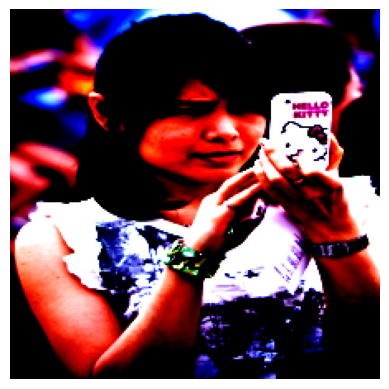

In [44]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


imagee_tensor1,actual_captions1=coco_dset[100]
img_array1 = imagee_tensor1.numpy()

# If the image tensor is in CHW format (channels, height, width), transpose it to HWC format
if img_array1.shape[0] == 3:
    img_array = img_array1.transpose(1, 2, 0)
print("GROUND CAPTIONS")
print(knn_results[100]['ground_captions'])
print("OUR CAPTION")
print(knn_results[100]['our_caption'])
# Create a plot
plt.imshow(img_array)
plt.axis('off')

# Show the plot
plt.show()



GROUND CAPTIONS
['an overhead view of many people on motorcycles ', 'The motorcycle riders have gathered in the mountains.', 'there are many motorcycles that are parked on the top of a mountain', 'A group of motorcycles parked on a dirt parking lot in a mountainous region.', 'A large group of people standing near some rocks.']
OUR CAPTION
A person on a motorcycle riding on a mountain.


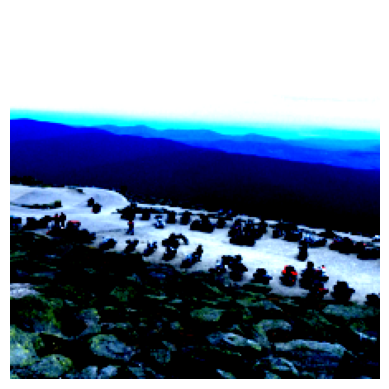

In [45]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


imagee_tensor1,actual_captions1=coco_dset[3020]
img_array1 = imagee_tensor1.numpy()

# If the image tensor is in CHW format (channels, height, width), transpose it to HWC format
if img_array1.shape[0] == 3:
    img_array = img_array1.transpose(1, 2, 0)
print("GROUND CAPTIONS")
print(knn_results[3020]['ground_captions'])
print("OUR CAPTION")
print(knn_results[3020]['our_caption'])
# Create a plot
plt.imshow(img_array)
plt.axis('off')

# Show the plot
plt.show()



GROUND CAPTIONS
['A vase filled with a large yellow and black sunflower and other flowers.', 'A vase contains a bouquet of flowers and a sunflower in front of a rustic brick wall.', 'A vase of flowers one being a large sunflower in front of a brick wall.', 'A blue vase with sunflowers and other flowers', 'Yellow sunflower sitting in a blue vase by a brick wall. ']
OUR CAPTION
A vase filled with lots of different colored flowers.


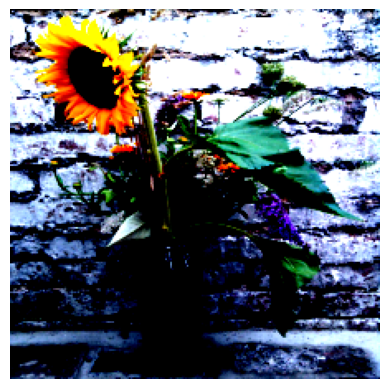

In [46]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


imagee_tensor1,actual_captions1=coco_dset[465]
img_array1 = imagee_tensor1.numpy()

# If the image tensor is in CHW format (channels, height, width), transpose it to HWC format
if img_array1.shape[0] == 3:
    img_array = img_array1.transpose(1, 2, 0)
print("GROUND CAPTIONS")
print(knn_results[465]['ground_captions'])
print("OUR CAPTION")
print(knn_results[465]['our_caption'])
# Create a plot
plt.imshow(img_array)
plt.axis('off')

# Show the plot
plt.show()



GROUND CAPTIONS
['A yellow and blue fire hydrant sitting on a sidewalk.', 'A yellow and blue fire hydrant on the sidewalk.', 'A freeway sign states Las Vegas north in the background behind a yellow and blue fire hydrant', 'A brightly colored fire hydrant sits beside a brightly colored curb.', 'A fire hydrant that is painted yellow and blue.']
OUR CAPTION
A fire hydrant that is sitting on the sidewalk.


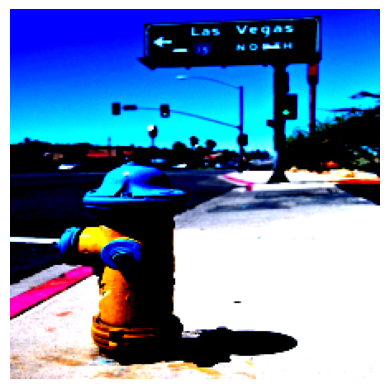

In [47]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


imagee_tensor1,actual_captions1=coco_dset[23200]
img_array1 = imagee_tensor1.numpy()

# If the image tensor is in CHW format (channels, height, width), transpose it to HWC format
if img_array1.shape[0] == 3:
    img_array = img_array1.transpose(1, 2, 0)
print("GROUND CAPTIONS")
print(knn_results[23200]['ground_captions'])
print("OUR CAPTION")
print(knn_results[23200]['our_caption'])
# Create a plot
plt.imshow(img_array)
plt.axis('off')

# Show the plot
plt.show()



GROUND CAPTIONS
['A lot of people that are looking at something.', 'A crowd of people standing next to each other holding up a Nintendo cell phone.', 'The people hold their phone up and make hand motions at the event.', 'Someone is using their phone as a light at a concert.', 'Several young people are enjoying a concert and recording via phones.']
OUR CAPTION
A person is holding up their cell phone to take a picture.


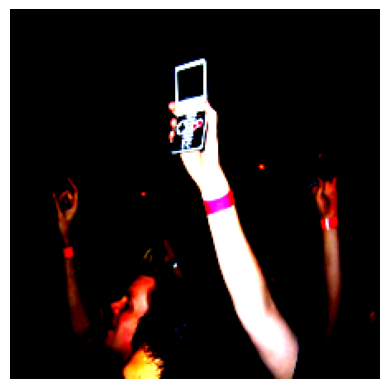

In [48]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


imagee_tensor1,actual_captions1=coco_dset[20302]
img_array1 = imagee_tensor1.numpy()

# If the image tensor is in CHW format (channels, height, width), transpose it to HWC format
if img_array1.shape[0] == 3:
    img_array = img_array1.transpose(1, 2, 0)
print("GROUND CAPTIONS")
print(knn_results[20302]['ground_captions'])
print("OUR CAPTION")
print(knn_results[20302]['our_caption'])
# Create a plo
plt.imshow(img_array)
plt.axis('off')

# Show the plot
plt.show()

